In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx0 = dsU.variables['vozocrtx'][time_s:time_f,:,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][time_s:time_f,:,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][time_s:time_f,:,y,x]
        print('W')
        vosaline0 = dsT.variables['vosaline'][time_s:time_f, :, y, x]
        print('S')
        sozotaux = dsU.variables['sozotaux'][time_s:time_f,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]
        tmask0 = dsM.variables['tmask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1)) 

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, vosaline, umask, vmask, tmask, depthu, sozotaux

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_salt_daily(time_s):
    time_f = time_s+24
    vozocrtx, vomecrty, vovecrtz, vosaline, umask, vmask, tmask, depthu, sozotaux = get_vels(dirname, fname, meshmaskname, time_s, time_f)
    vosaline_daily = np.mean(vosaline, axis=0)
    vozocrtx_daily = np.mean(vozocrtx, axis=0)
    vomecrty_daily = np.mean(vomecrty, axis=0)
    vovecrtz_daily = np.mean(vovecrtz, axis=0)
    return vosaline_daily, vozocrtx_daily, vomecrty_daily, vovecrtz_daily, depthu

def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [4]:
def plot(vozocrtx_daily_all, vomecrty_daily_all, vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins):

    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, gridspec_kw={'width_ratios': [5, 5, 5, 0.1]}, 
                             figsize=(20, 13))

    for col in range(3):
        vosaline_daily = vosaline_daily_all[col]
        vozocrtx = vozocrtx_daily_all[col]
        vomecrty = vomecrty_daily_all[col]
        
        for row in range(2):
            ax=axes[row, col]
            vmin = vmins[row]
            vmax = vmaxs[row]
            salt = salt_all[row]
            cmap = cmo.cm.matter
            cmap.set_bad('silver')
            arrow=1
            arr = 10

            # Initial depth
            depth_initial = get_varb_surf(vosaline_ref_profile, salt, depthu)
            
            # Particular day
            
            u_daily = get_varb_surf(vosaline_daily, salt, vozocrtx)
            v_daily = get_varb_surf(vosaline_daily, salt, vomecrty)
            x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(u_daily, v_daily, arrow)
            print(col, row, np.nanmin(speeds), np.nanmax(speeds))
            
            p = ax.pcolormesh(x_slice, y_slice, speeds, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.quiver(x_slice[::arr], y_slice[::arr], u_nstg[::arr, ::arr], v_nstg[::arr, ::arr],
                      color='k', pivot='mid', width=0.0035, headwidth=2.4, clim=[vmin,vmax])

            ax.tick_params(axis='both', which='both', length=0)
            ax.set_aspect(aspect='equal')
            ax.set_xlim([0, x_slice[-1]])
            ax.set_ylim([0, y_slice[-1]])

            if row==0: ax.set_title(ttls[col], fontsize=25, y=1.08)
            else: pass

            if row==1: ax.set_xlabel('x-indices', fontsize=19)
            else:pass

            if col==0:
                ax.set_ylabel('y-indices', fontsize=19)
                ax.annotate(water_mass[row], xy=(0, 0.5), xytext=(-80, 0),
                            xycoords=('axes fraction'), textcoords='offset points',
                            size=25, ha='center', va='center', rotation='vertical')
            else: pass

            if col==2:
                axc = axes[row, 3] 
                axc.axis('off')
                cbar = fig.colorbar(p, ax=axc, orientation='vertical', fraction=5.5, aspect=15)
            #cbar.set_ticks(ticks)
            #cbar.set_ticklabels(ticks)
            ax.contour(x_slice, y_slice, bathy[1:, 1:], levels=depth_initial, colors='k', alpha=0.9, linewidths=2)

    fig.patch.set_facecolor('white')    
    fig.tight_layout(w_pad=0.5, h_pad=1.0)
    plt.subplots_adjust(top=0.96)
    
    return fig

In [5]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

time_s_day1 = 24*0+11 # day 1
time_s_day2 = 24*1+11 # day 2
time_s_day5 = 24*4+11 # day 5

# LANSARD ET AL.: WATER MASSES IN THE BEAUFORT SEA 
# https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2011JC007299

salt_UHW_SA_min, salt_ATW_SA_min = 33.06159919830441, 34.97093167480222
salt_UHW_SA_max, salt_ATW_SA_max = 33.46356393019869, 35.01112814799166
salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694

ttls = ['Day 1 Average', 'Day 2 Average', 'Day 5 Average']
water_mass = ['Upper halocline water', 'Atlantic water']
salt_all = [salt_UHW_SA, salt_ATW_SA]

# Ideal

In [6]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [7]:
vosaline_daily1, vozocrtx_daily1, vomecrty_daily1, vovecrtz_daily1, depthu = get_salt_daily(time_s_day1)
vosaline_daily2, vozocrtx_daily2, vomecrty_daily2, vovecrtz_daily2, depthu = get_salt_daily(time_s_day2)
vosaline_daily5, vozocrtx_daily5, vomecrty_daily5, vovecrtz_daily5, depthu = get_salt_daily(time_s_day5)

files
U
V
W
S
files
U
V
W
S
files
U
V
W
S


In [8]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vozocrtx_daily_all = [vozocrtx_daily1, vozocrtx_daily2, vozocrtx_daily5]
vomecrty_daily_all = [vozocrtx_daily1, vomecrty_daily2, vomecrty_daily5]
vmaxs = [0.8, 0.4]
vmins = [0, 0]

0 0 0.0014078121676808606 0.8576253665135463
0 1 0.00792702851850169 0.2537188234530028
1 0 0.0015400559753922858 0.664678837044463
1 1 0.001308286047770744 0.2086855703749039
2 0 0.0014126995633634064 0.6039122825432626
2 1 0.013258446391137898 0.07802048033301438


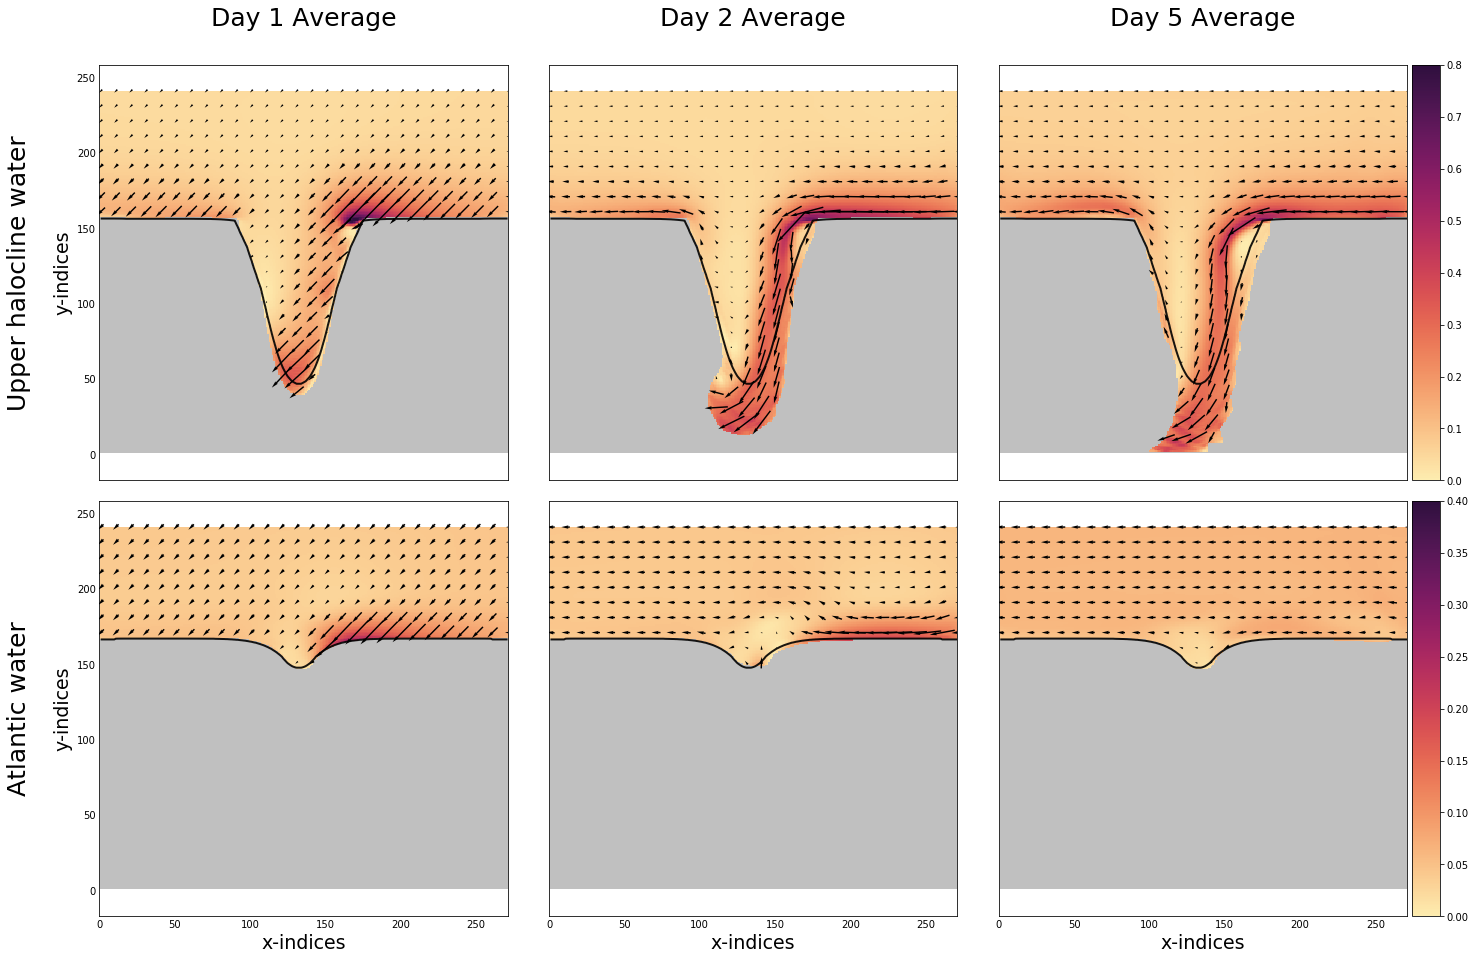

In [9]:
fig = plot(vozocrtx_daily_all, vomecrty_daily_all, vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins)
fig.savefig('./surface_watermass_speeds_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Real

In [10]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/1_real_bathy_for_agrif_fix.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [11]:
vosaline_daily1, vozocrtx_daily1, vomecrty_daily1, vovecrtz_daily1, depthu = get_salt_daily(time_s_day1)
vosaline_daily2, vozocrtx_daily2, vomecrty_daily2, vovecrtz_daily2, depthu = get_salt_daily(time_s_day2)
vosaline_daily5, vozocrtx_daily5, vomecrty_daily5, vovecrtz_daily5, depthu = get_salt_daily(time_s_day5)

files
U
V
W
S
files
U
V
W
S
files
U
V
W
S


In [12]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vozocrtx_daily_all = [vozocrtx_daily1, vozocrtx_daily2, vozocrtx_daily5]
vomecrty_daily_all = [vozocrtx_daily1, vomecrty_daily2, vomecrty_daily5]
vmaxs = [0.8, 0.4]
vmins = [0, 0]

0 0 3.0051143284064227e-05 0.6487926726967894
0 1 6.753538315243482e-05 0.2291097054344522
1 0 0.005995019347448385 0.516765650564017
1 1 3.804623627968179e-05 0.20879700192699563
2 0 0.0023120852049695467 0.42198191270549607
2 1 0.008284129266753659 0.1105258285904814


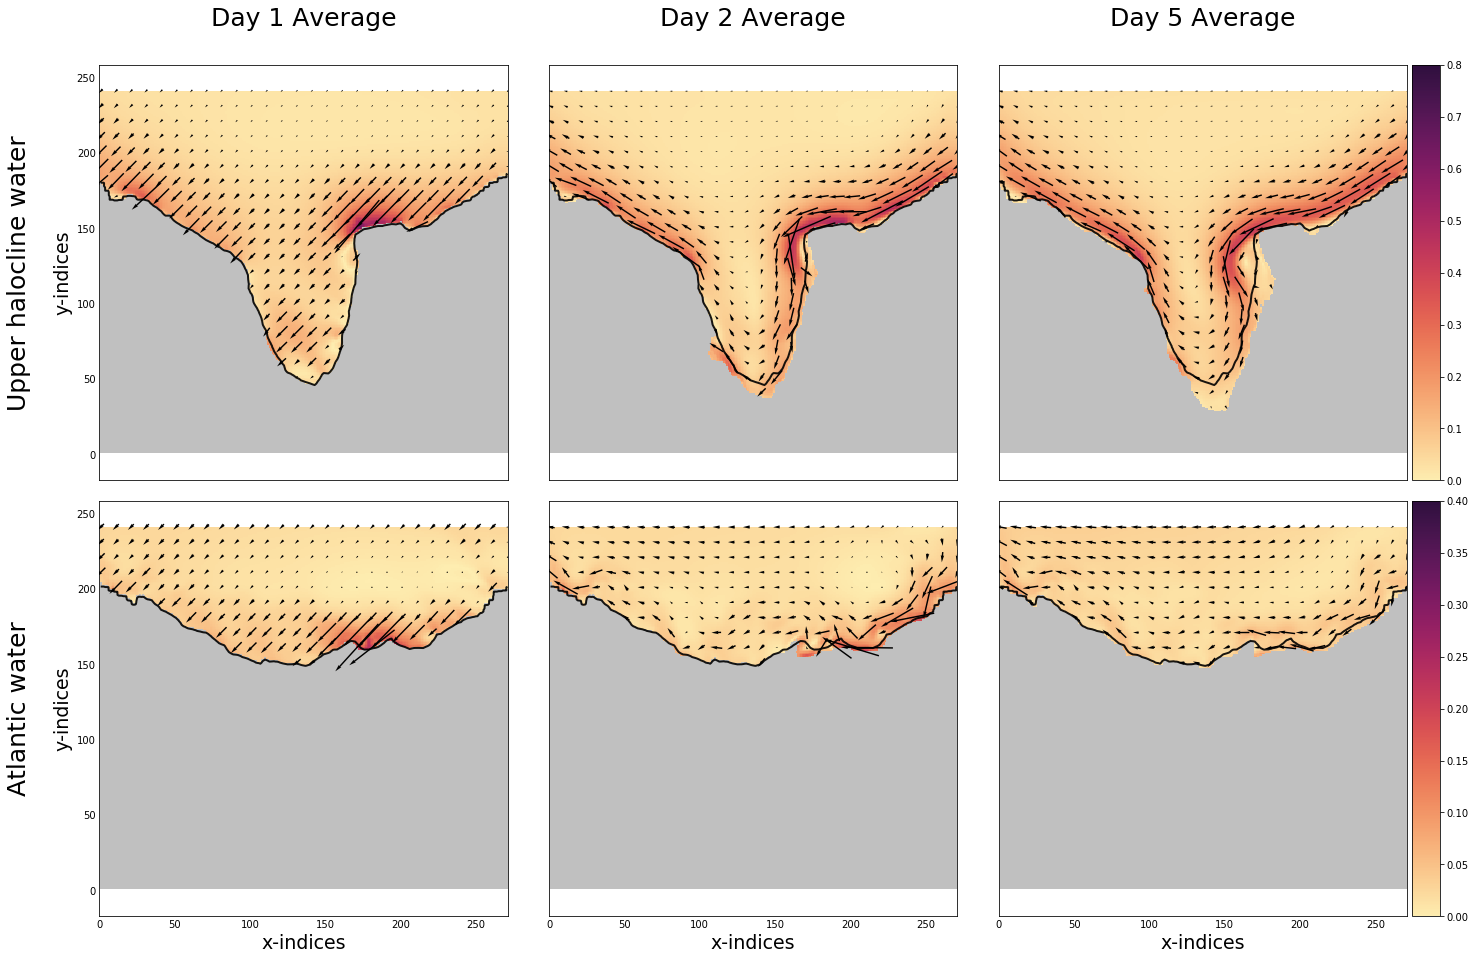

In [13]:
fig = plot(vozocrtx_daily_all, vomecrty_daily_all, vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins)
fig.savefig('./surface_watermass_speeds_real.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())